In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from itertools import product
from PIL import Image

from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature
from captum.attr import IntegratedGradients, GuidedGradCam
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeAggresiveTransforms, makeDefaultTransforms, resizeCropTransforms

In [6]:
# Script runtime options
model = 'inceptionv4'
root_dir = '..'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [7]:
# Get image transforms
# Get data transforms
data_transforms = makeDefaultTransforms(img_crop_size=299, img_resize=512)

# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2, )
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [8]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [9]:
# Load the best model from file
model_ = torch.load(model_file)
_ = model_.to(device).eval()

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


ModuleNotFoundError: No module named 'pytorchcv'

In [6]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [87]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

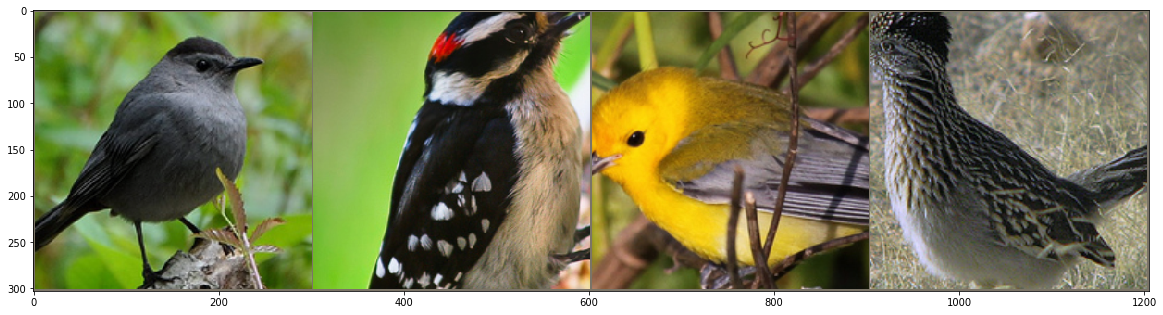

GroundTruth:  019.Gray_Catbird 192.Downy_Woodpecker 177.Prothonotary_Warbler 110.Geococcyx
Predicted:  019.Gray_Catbird 192.Downy_Woodpecker 177.Prothonotary_Warbler 110.Geococcyx


In [88]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))
images = images.to(device)
labels = labels.to(device)
outputs = model_(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(4)))

In [90]:
ind = 1
input = images[ind].unsqueeze(0)
input.requires_grad = True

In [91]:
def attribute_image_features(algorithm, input, **kwargs):
    model_.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [92]:
saliency = Saliency(model_)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [93]:
ig = IntegratedGradients(model_)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.4830], device='cuda:0', dtype=torch.float64)


In [94]:
# Memory issues
#ig = IntegratedGradients(model_)
#nt = NoiseTunnel(ig)
#attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
#                                      n_samples=100, stdevs=0.2)
#attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [95]:
dl = DeepLift(model_)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: 192.Downy_Woodpecker
Predicted: 192.Downy_Woodpecker  Probability: 0.9819767475128174


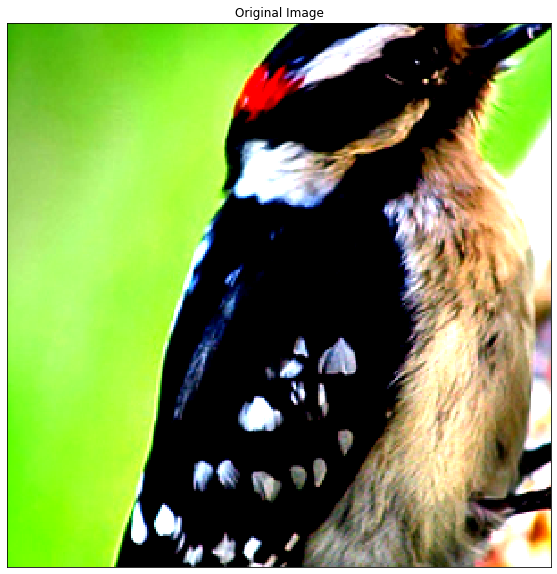

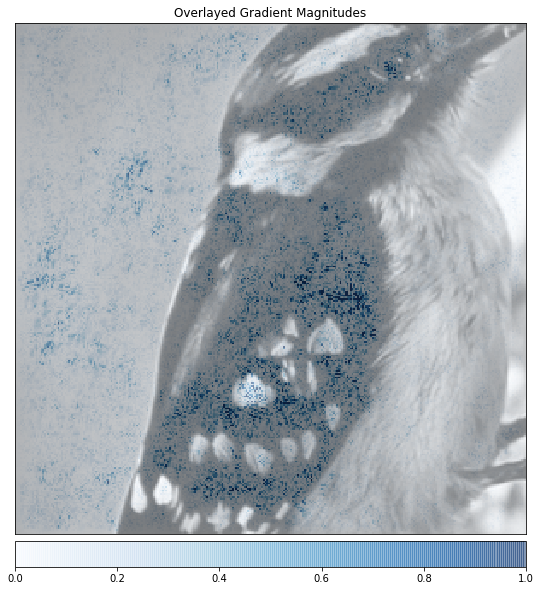

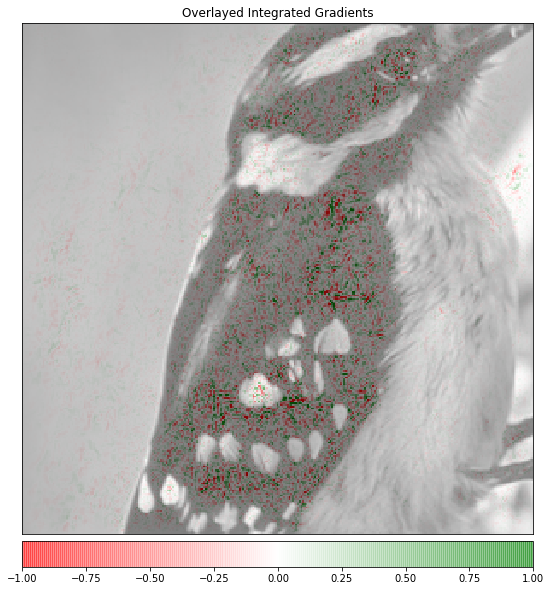

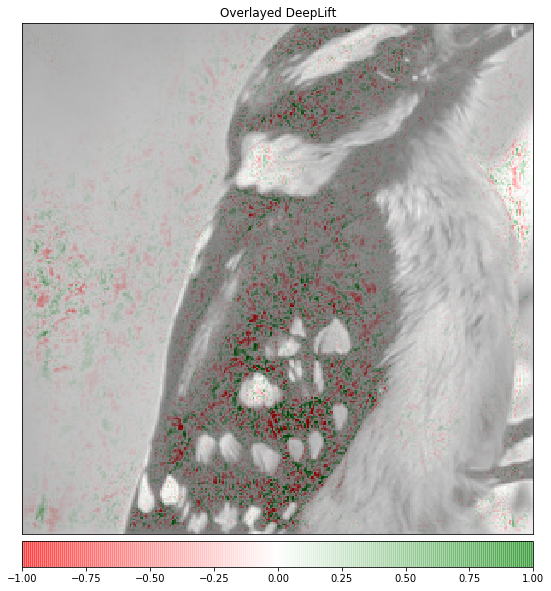

In [96]:
fig_size=(10,10)

print('Actual: {}'.format(class_names[labels[ind]]))
print('Predicted:', class_names[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, fig_size=fig_size,
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes",fig_size=fig_size,)

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients",fig_size=fig_size,)

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift",fig_size=fig_size,)

In [113]:
gGradCam = GuidedGradCam(model_, layer=model_.module.features.stage3.unit4)
ggCam = gGradCam.attribute(input, target=labels[ind].item())
ggCam = np.transpose(ggCam.squeeze().cpu().detach().numpy(), (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


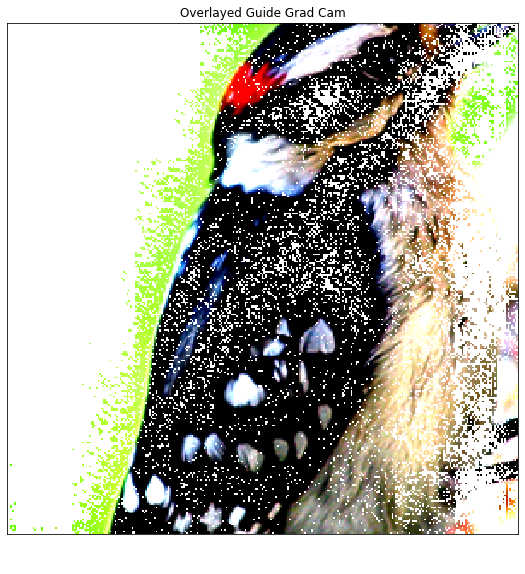

In [114]:
_ = viz.visualize_image_attr(ggCam, original_image, method="alpha_scaling",sign="absolute_value",show_colorbar=True, 
                          title="Overlayed Guide Grad Cam",fig_size=fig_size, alpha_overlay=0.5, cmap='gist_rainbow')

In [ ]:
model_.